# Regridding climate model data
Climate models are run on grids that are optimized for numerical stability and efficiency. Prior to CMIP6 modeling centers regridded the data first, then shared the data worldwide. This made it easy to calculate direct comparisons. However, interpolation does add uncertainty, so people doing more complicated analyses, for example calculating the transport of water vapor based on 3D wind fields, requested the data be shared on the model grid. Generally, that means that _scalar_ quantities (like ice thickness and concentration) will be reported for different locations of a grid cell than _vector_ quantities (like velocity). In this notebook, we'll use a library called `xesmf` to regrid data. The reason for using `xesmf` rather than the interpolation code from `scipy` is that the model grids are often curvilinear -- the spacing between points may vary.

You'll need to use regridding for two different scenarios:
1. If the sea ice velocity $u$ and $v$ components are on different portions of the grid cell than each other, you'll need to regrid them before you can compute the drift speed.
2. When you compare the sea ice properties to the wind, you'll need to align the ice to the atmosphere grid.

As an example we'll start with GFDL-CM4. From the dataset attributes, we learn that the ocean and sea ice are on a "tripolar" grid. As you might guess, having a pole in the grid, like a lat/lon grid, makes it hard to solve differential equations. The tripolar grid hides the poles under land, so for ocean coordinates, the grid is always boxes.

You can check to see if data points are on a "T" grid (temperature, which is scalar, is usually at the center of a cell) or on a "U" grid (velocity, on grid edges).

In [2]:
import xarray as xr
import xesmf as xe
import intake
import numpy as np
import pandas as pd

In [45]:
import warnings
warnings.filterwarnings("ignore")

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
models = col.df['source_id'].unique()

# cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
# col = intake.open_esm_datastore(cat_url)

First, let's get a list of all the models where we have complete CMIP6 historical and middle-of-the-road SSPs

In [33]:
variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']
query = col.search(
    activity_id=['CMIP', 'ScenarioMIP'], #later we will add an SSP to extend the dataset to 2024
    # source_id=source_id,
    table_id=['SImon', 'Amon'],
    member_id='r1i1p1f1',
    variable_id=variables,
)

for source_id, table in query.df.groupby('source_id'):
    print(source_id, np.unique(table['activity_id']))

ACCESS-CM2 ['CMIP' 'ScenarioMIP']
ACCESS-ESM1-5 ['CMIP' 'ScenarioMIP']
AWI-CM-1-1-MR ['CMIP' 'ScenarioMIP']
AWI-ESM-1-1-LR ['CMIP']
BCC-CSM2-MR ['CMIP' 'ScenarioMIP']
BCC-ESM1 ['CMIP']
CAMS-CSM1-0 ['CMIP' 'ScenarioMIP']
CAS-ESM2-0 ['CMIP' 'ScenarioMIP']
CESM2 ['CMIP']
CESM2-FV2 ['CMIP']
CESM2-WACCM ['CMIP' 'ScenarioMIP']
CESM2-WACCM-FV2 ['CMIP']
CIESM ['CMIP' 'ScenarioMIP']
CMCC-CM2-HR4 ['CMIP']
CMCC-CM2-SR5 ['CMIP' 'ScenarioMIP']
CMCC-ESM2 ['CMIP' 'ScenarioMIP']
CanESM5 ['CMIP' 'ScenarioMIP']
E3SM-1-0 ['CMIP']
E3SM-1-1 ['CMIP' 'ScenarioMIP']
E3SM-1-1-ECA ['CMIP']
EC-Earth3 ['CMIP' 'ScenarioMIP']
EC-Earth3-AerChem ['CMIP' 'ScenarioMIP']
EC-Earth3-CC ['CMIP' 'ScenarioMIP']
EC-Earth3-LR ['CMIP']
EC-Earth3-Veg ['CMIP' 'ScenarioMIP']
EC-Earth3-Veg-LR ['CMIP' 'ScenarioMIP']
FGOALS-f3-L ['CMIP' 'ScenarioMIP']
FGOALS-g3 ['CMIP' 'ScenarioMIP']
FIO-ESM-2-0 ['CMIP' 'ScenarioMIP']
GFDL-AM4 ['CMIP']
GFDL-CM4 ['CMIP' 'ScenarioMIP']
GFDL-ESM4 ['CMIP' 'ScenarioMIP']
GISS-E2-1-G ['CMIP']
GISS-E2-1-G-C

In [34]:
variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']
query = col.search(
    experiment_id=['historical'], 
    table_id=['SImon', 'Amon'],
    member_id='r1i1p1f1',
    variable_id=variables,
)

complete_list = []
incomplete = []
for name, group in query.df.groupby('source_id'):
    has_data = False

    check_variables = [v in group['variable_id'].values for v in variables]
    has_data = np.all(check_variables)

    if has_data:
        complete_list.append(name)
        
    else:
        incomplete.append([name, len(group), ','.join([v for v in variables if v not in group['variable_id'].values]), has_data])
incomplete_df = pd.DataFrame(incomplete, columns=['source_id', 'n', 'missing_variables', 'historical_complete'])

In [66]:
incomplete_df

,source_id,n,missing_variables,historical_complete
0,AWI-CM-1-1-MR,4,siconc,False
1,BCC-CSM2-MR,4,sithick,False
2,BCC-ESM1,4,sithick,False
3,CAMS-CSM1-0,4,sithick,False
4,CAS-ESM2-0,3,"sfcWind,sithick",False
5,CIESM,4,sfcWind,False
6,CMCC-CM2-HR4,4,sithick,False
7,CanESM5,4,sithick,False
8,E3SM-1-1,3,"siu,siv",False
9,E3SM-1-1-ECA,3,"siu,siv",False


In [62]:
# Let's check the ensemble members also.
complete = pd.Series([len(complete_list[x]) for x in complete_list],
          index = [x for x in complete_list])

In [65]:
print(complete.to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
ACCESS-CM2 & 3 \\
ACCESS-ESM1-5 & 7 \\
AWI-ESM-1-1-LR & 1 \\
CESM2 & 5 \\
CESM2-FV2 & 3 \\
CESM2-WACCM & 3 \\
CESM2-WACCM-FV2 & 1 \\
CMCC-CM2-SR5 & 1 \\
CMCC-ESM2 & 1 \\
CNRM-CM6-1 & 10 \\
CNRM-ESM2-1 & 5 \\
CanESM5 & 7 \\
E3SM-1-0 & 5 \\
EC-Earth3 & 6 \\
EC-Earth3-AerChem & 2 \\
EC-Earth3-CC & 1 \\
EC-Earth3-Veg & 5 \\
EC-Earth3-Veg-LR & 3 \\
GFDL-CM4 & 1 \\
GFDL-ESM4 & 1 \\
GISS-E2-1-H & 25 \\
HadGEM3-GC31-LL & 3 \\
IPSL-CM6A-LR & 8 \\
IPSL-CM6A-LR-INCA & 1 \\
KIOST-ESM & 1 \\
MIROC-ES2L & 7 \\
MIROC6 & 10 \\
MPI-ESM-1-2-HAM & 3 \\
MPI-ESM1-2-HR & 10 \\
MPI-ESM1-2-LR & 10 \\
NorESM2-LM & 2 \\
NorESM2-MM & 2 \\
SAM0-UNICON & 1 \\
UKESM1-0-LL & 8 \\
\bottomrule
\end{tabular}



In [36]:
variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']
query = col.search(
    activity_id=['CMIP'],
    source_id=complete_list,
    table_id=['SImon', 'Amon'],
    variable_id='siu', # Just grabbing one variable to do the count of ensemble members
)
number_ensemble_members = query.df.groupby('source_id').count()[['member_id']]
models = list(number_ensemble_members.index)

Still TBD: some member IDs may be missing data. A similiar table lookup can go through each member ID and make sure that the data is complete.

# Identifying cases where re-gridding the sea ice velocity is necessary
Next, we'll be looking to see if the lat/lon grids for siu, siv, and/or siconc differ. While we'll need to do regridding for all the comparisons with wind speed, the list here will be the ones where we need to regrid before we can even get the sea ice velocity.

In [52]:
variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']
query = col.search(
    experiment_id=['historical'], 
    table_id=['SImon', 'Amon'],
    source_id=models,
    variable_id=variables,
)
print('source_id'.ljust(15), 'ensemble'.ljust(10), ' '.join(x.ljust(6) for x in variables))
print('')
complete_list = {}
incomplete = []
for name, group in query.df.groupby('source_id'):
    for ens, group_ens in group.groupby('member_id'):
        has_data = False
        check_variables = [v in group_ens['variable_id'].values for v in variables]
        has_data = np.all(check_variables)
        if not has_data:
            print(' '.join([name.ljust(15), ens.ljust(10)] + [str(x).ljust(6) for x in check_variables]))
            incomplete.append([name, ens] + check_variables)
        else:
            if name in complete_list:
                complete_list[name].append(ens)
            else:
                complete_list[name] = [ens]

source_id       ensemble   siu    siv    siconc sfcWind sithick

ACCESS-CM2      r4i1p1f1   False  False  True   False  False 
ACCESS-CM2      r5i1p1f1   False  False  True   False  False 
ACCESS-ESM1-5   r10i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r11i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r12i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r13i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r14i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r15i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r16i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r17i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r18i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r19i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r20i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r21i1p1f1  False  False  True   True   True  
ACCESS-ESM1-5   r22i1p1f1  False  False  True   True   True  
ACCES

In [54]:
incomplete = pd.DataFrame(incomplete, columns=['source_id', 'member_id'] +  variables)

In [57]:
pd.DataFrame(complete)

NameError: name 'complete' is not defined

In [56]:
incomplete[['source_id', 'siu','siv','siconc','sfcWind','sithick']].groupby('source_id').sum()

,siu,siv,siconc,sfcWind,sithick
source_id,,,,,
ACCESS-CM2,0,0,2,0,0
ACCESS-ESM1-5,0,0,33,23,23
AWI-CM-1-1-MR,5,5,0,5,5
BCC-CSM2-MR,3,3,3,3,0
BCC-ESM1,3,3,3,3,0
CAMS-CSM1-0,2,3,3,3,0
CAS-ESM2-0,2,2,4,0,0
CESM2,5,0,6,6,6
CESM2-WACCM-FV2,2,0,2,2,2


In [44]:
for x in complete_list:
    print(x.ljust(20), len(complete_list[x]))

ACCESS-CM2           3
ACCESS-ESM1-5        7
AWI-ESM-1-1-LR       1
CESM2                5
CESM2-FV2            3
CESM2-WACCM          3
CESM2-WACCM-FV2      1
CMCC-CM2-SR5         1
CMCC-ESM2            1
E3SM-1-0             5
EC-Earth3            6
EC-Earth3-AerChem    2
EC-Earth3-CC         1
EC-Earth3-Veg-LR     3
GFDL-CM4             1
GFDL-ESM4            1
GISS-E2-1-H          25
IPSL-CM6A-LR         8
IPSL-CM6A-LR-INCA    1
KIOST-ESM            1
MIROC6               10
MPI-ESM-1-2-HAM      3
MPI-ESM1-2-HR        10
MPI-ESM1-2-LR        10
SAM0-UNICON          1


In [31]:
query = col.search(
    experiment_id=['historical'], 
    table_id=['SImon', 'Amon'],
    source_id='CESM2',
    variable_id=['siu', 'siv'],
)
for x in query.df['zstore']:
    print(x)

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/SImon/siu/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5i1p1f1/SImon/siu/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3i1p1f1/SImon/siu/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4i1p1f1/SImon/siu/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6i1p1f1/SImon/siu/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2i1p1f1/SImon/siu/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7i1p1f1/SImon/siu/gn/v20190311/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8i1p1f1/SImon/siu/gn/v20190311/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9i1p1f1/SImon/siu/gn/v20190311/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/SImon/siu/gn/v20190313/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/SImon/siv/gn/v20191216/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5i1p1f1/SImon/siv/gn/v20191216/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6i1p1f1/SImon/siv/gn/v20191216

In [44]:
for source_id in number_ensemble_members.index:
    # Get the 
    small_query = col.search(
        experiment_id=['historical'], #, "ssp585"], later we will add an SSP to extend the dataset to 2024
        source_id=source_id,
        table_id='SImon',
        member_id='r1i1p1f1',
        variable_id=['siu', 'siv', 'siconc'])
    break

In [46]:
ds_dict = small_query.to_dataset_dict(aggregate=False)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [47]:
source_id

'ACCESS-CM2'

In [50]:
variables = ['siu', 'siv', 'siconc']
var_keys = {}
for var in variables:
    var_keys[var] = []
    for x in ds_dict.keys():
        if var in x:
            var_keys[var].append(x)
var_keys

{'siu': ['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.r1i1p1f1.SImon.siu.gn.gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/SImon/siu/gn/v20200817/.20200817'],
 'siv': ['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.r1i1p1f1.SImon.siv.gn.gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/SImon/siv/gn/v20200817/.20200817'],
 'siconc': ['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.r1i1p1f1.SImon.siconc.gn.gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/SImon/siconc/gn/v20200817/.20200817']}

In [53]:
ds_dict[var_keys['siu'][0]].latitude

<xarray.DataArray 'latitude' (j: 300, i: 360)>
dask.array<open_dataset-latitude, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    bounds:         vertices_latitude
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [69]:
np.max(ds_dict[var_keys['siu'][0]]['latitude'].to_numpy() - ds_dict[var_keys['siv'][0]]['latitude'].to_numpy())
np.max(ds_dict[var_keys['siu'][0]]['longitude'].to_numpy() - ds_dict[var_keys['siv'][0]]['longitude'].to_numpy())
np.max(ds_dict[var_keys['siu'][0]]['latitude'].to_numpy() - ds_dict[var_keys['siconc'][0]]['latitude'].to_numpy())
np.max(ds_dict[var_keys['siu'][0]]['longitude'].to_numpy() - ds_dict[var_keys['siconc'][0]]['longitude'].to_numpy())

116.17692565917969

In [94]:
source_id='CESM2'

# Get the grid information - only need first member here
grid_query = col.search(
    experiment_id='historical',
    member_id = 'r1i1p1f1',
    variable_id=['areacella', 'areacello'],
    source_id=source_id
)
grid_info = grid_query.to_dataset_dict(zarr_kwargs={'consolidated': True})
grid_info.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.NCAR.CESM2.historical.fx.gn', 'CMIP.NCAR.CESM2.historical.Ofx.gr', 'CMIP.NCAR.CESM2.historical.Ofx.gn'])

In [63]:
query = col.search(
    experiment_id=['historical'], #, "ssp585"], later we will add an SSP to extend the dataset to 2024
    source_id=source_id,
    table_id='SImon',
    member_id='r1i1p1f1',
    variable_id=['siu', 'siv', 'siconc'],
)
query.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,SImon,siu,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r1i1p1f1,SImon,siv,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20191216


In [65]:
ds_dict = query.to_dataset_dict(aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Setting "aggregate=False" means that it's not going to try to merge datasets -- we'll get a separate dataset for each variable. One reason that the function was failing earlier is that it would try to merge everything from the same model into one dataset. Since that lat/lon coordinates can be different depending on where inside a grid cell the data point is, this leads to conflicts between variables.

{'siu': ['CMIP.NCAR.CESM2.historical.r1i1p1f1.SImon.siu.gn.gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/SImon/siu/gn/v20190308/.20190308'],
 'siv': ['CMIP.NCAR.CESM2.historical.r1i1p1f1.SImon.siv.gn.gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/SImon/siv/gn/v20191216/.20191216'],
 'siconc': ['CMIP.NCAR.CESM2.historical.r1i1p1f1.SImon.siconc.gn.gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/SImon/siconc/gn/v20190308/.20190308']}

In [67]:
ds_dict[var_keys['siu'][0]]

<xarray.Dataset>
Dimensions:         (nj: 384, ni: 320, nvertices: 4, member_id: 1,
                     dcpp_init_year: 1, time: 1980, d2: 2)
Coordinates:
    lat             (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds        (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon             (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds        (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * ni              (ni) int32 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * nj              (nj) int32 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds       (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: nvertices, d2
Data variables:
    siu             (member_id, dcpp_init_year, time, nj, ni) float32 dask.array<chunksize=(1, 1, 949, 384, 320), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:variable_id:     siu
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190308
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.r1i1p1f1.SIm...

In [71]:
import proplot as pplt
import numpy as np
import warnings
warnings.simplefilter('ignore')
pplt.rc['reso'] = 'med'
pplt.rc['cartopy.circular'] = False


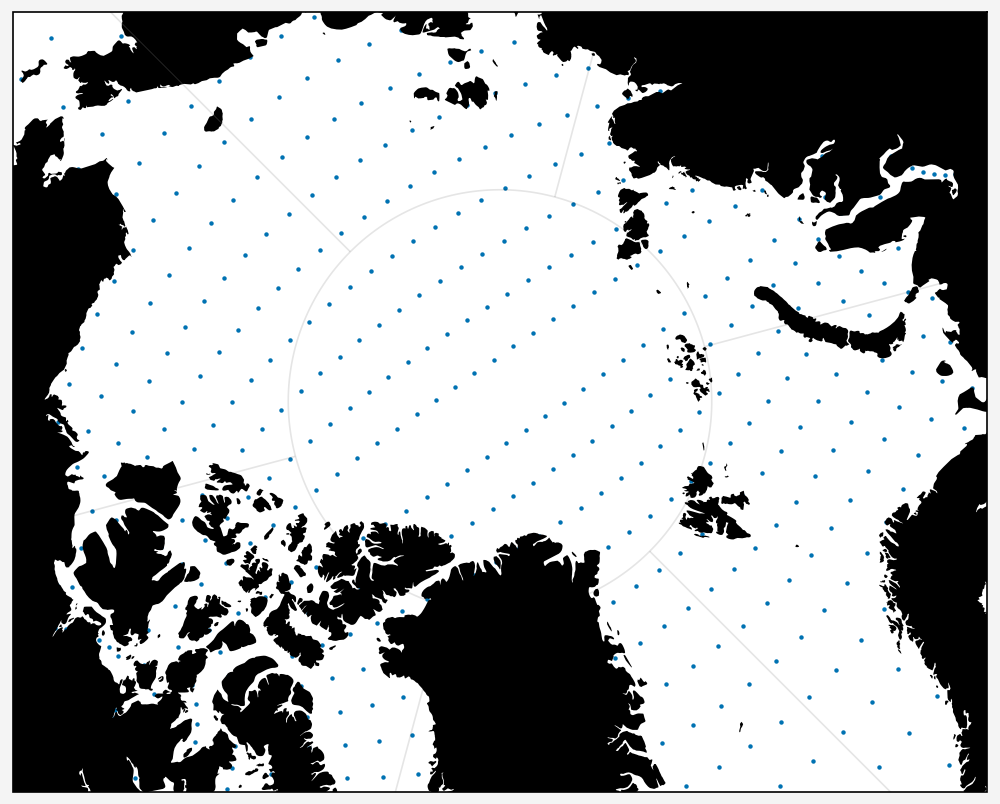

In [73]:
import cartopy.crs as ccrs
crs = ccrs.CRS('epsg:3413')

fig, ax = pplt.subplots(proj='npstere', width=5, proj_kw={'lon_0': -45})
ax.format(land=True)
ax.set_extent([-2.5e6, 2.5e6, -2e6, 2e6], crs=crs)

lats = ds_dict[var_keys['siu'][0]].latitude.data[::5, ::5]
lons = ds_dict[var_keys['siu'][0]].longitude.data[::5, ::5]
ax.scatter(np.ravel(lons), np.ravel(lats), ms=1)
# ax.format(title='CESM Ocean Grid (5 pt spacing)')

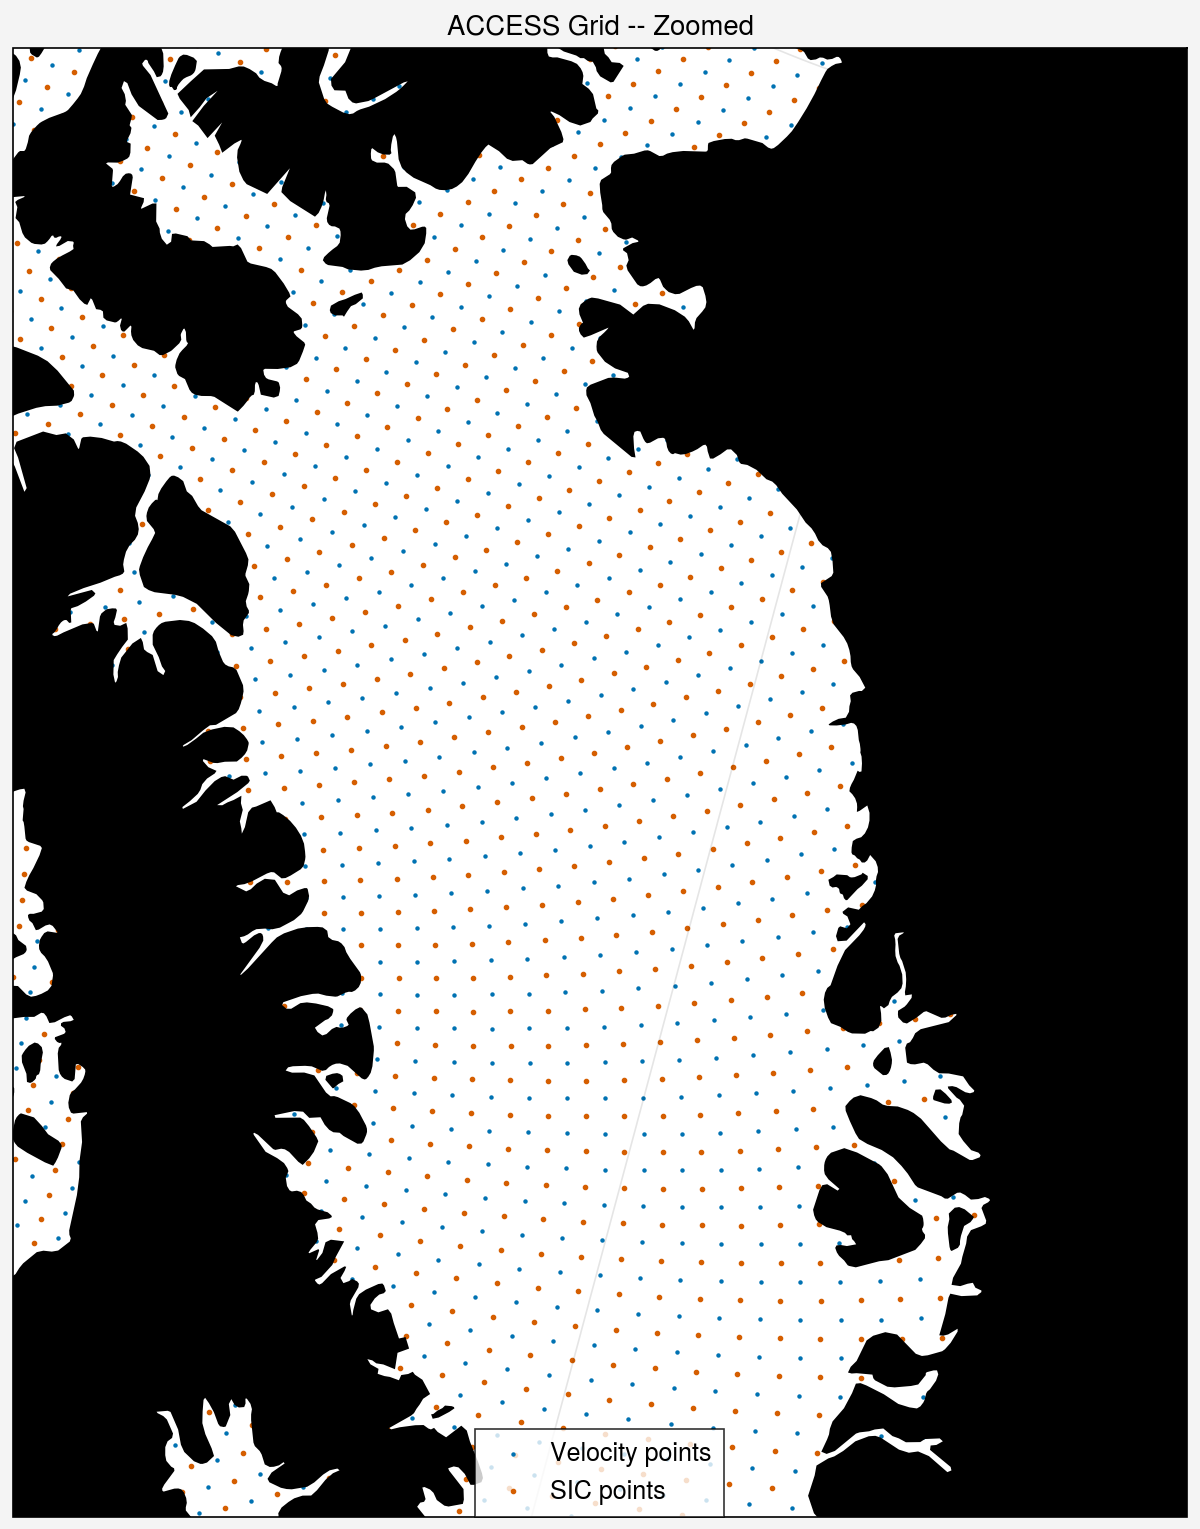

In [74]:
import cartopy.crs as ccrs
crs = ccrs.CRS('epsg:3413')

fig, ax = pplt.subplots(proj='npstere', width=6, proj_kw={'lon_0': -45})
ax.format(land=True)
ax.set_extent([-1.2e6, -0.2, -2.5e6, -1e6], crs=crs)

lats = ds_dict[var_keys['siu'][0]].latitude.data
lons = ds_dict[var_keys['siu'][0]].longitude.data
ax.scatter(np.ravel(lons), np.ravel(lats), ms=1, label='Velocity points')
ax.format(title='ACCESS Grid -- Zoomed')

lats = ds_dict[var_keys['siconc'][0]].latitude.data
lons = ds_dict[var_keys['siconc'][0]].longitude.data
ax.scatter(np.ravel(lons), np.ravel(lats), ms=2, label='SIC points')
ax.legend(ncols=1)

In [78]:
ds['siu'].squeeze()

<xarray.DataArray 'siu' (time: 1980, j: 300, i: 360)>
dask.array<getitem, shape=(1980, 300, 360), dtype=float32, chunksize=(782, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * i               (i) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * j               (j) int32 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
    latitude        (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude       (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Attributes:
    cell_methods:    area: time: mean where sea_ice (comment: mask=siconc)
    comment:         The x-velocity of ice on native model grid
    history:         2020-08-17T01:22:37Z altered by CMOR: Converted units fr...
    long_name:       X-Component of Sea-Ice Velocity
    original_units:  m/s
    standard_name:   sea_ice_x_velocity
    units:           m s-1

In [102]:
# Regridding 1: Sea ice velocity to ice concentration location

# U-component of velocity
ds = ds_dict[var_keys['siu'][0]] 
ds_in = xr.Dataset({'siu': (('time', 'xc', 'yc'), ds['siu'].squeeze().to_numpy())},
                   coords={'time': (('time',), ds['time'].squeeze().to_numpy()),
                           'lon': (('xc', 'yc'), ds['longitude'].squeeze().to_numpy()),
                           'lat': (('xc', 'yc'), ds['latitude'].squeeze().to_numpy())})

# Use the SIC grid
ds_sic = ds_dict[var_keys['siconc'][0]]
ds_out = xr.Dataset(coords={'lon': (('xc', 'yc'), ds_sic['longitude'].squeeze().to_numpy()),
                            'lat': (('xc', 'yc'), ds_sic['latitude'].squeeze().to_numpy())})
regridder = xe.Regridder(ds_in, ds_out, "bilinear")
ds_regridded = regridder(ds_in)

# TBD: Set up the new dataset with variable names


# for x in ds_regridded.attrs:
#     attrs[x] = ds_regridded.attrs[x]
    
# attrs['crs'] = proj_XY
# ds_regridded.attrs = attrs

In [83]:
# Regridding 2: Ocean grid to atmospheric grid for comparison with wind speed

In [103]:
ds_regridded

<xarray.Dataset>
Dimensions:  (time: 1980, xc: 300, yc: 360)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    lat      (xc, yc) float64 -77.88 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    lon      (xc, yc) float64 80.5 81.5 82.5 83.5 ... 79.94 79.96 79.97 79.99
Dimensions without coordinates: xc, yc
Data variables:
    siu      (time, xc, yc) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear

In [107]:
ds_sic.lat_bnds.sel(nvertices=1)

<xarray.DataArray 'lat_bnds' (nj: 384, ni: 320)>
dask.array<getitem, shape=(384, 320), dtype=float32, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat       (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds  (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon       (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds  (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * ni        (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj        (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
Attributes:
    units:    degrees_north

In [96]:
grid_info['CMIP.NCAR.CESM2.historical.Ofx.gr']

<xarray.Dataset>
Dimensions:         (member_id: 1, dcpp_init_year: 1, lat: 180, lon: 360,
                     d2: 2, lev: 33)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bnds        (lat, d2) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lev             (lev) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
    lev_bnds        (lev, d2) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bnds        (lon, d2) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: d2
Data variables:
    areacello       (member_id, dcpp_init_year, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:variable_id:     areacello
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190308
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Ofx.gr

In [71]:
# variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']
query = col.search(
    experiment_id=['historical'], 
    # table_id=['SIday'],
    # variable_id=variables,
)
query.df.table_id.unique()

array(['AERmon', 'Amon', 'day', 'Omon', 'SImon', 'Oyr', '3hr', 'AERmonZ',
       '6hrPlevPt', '6hrLev', 'Eday', 'EdayZ', 'Oday', 'Lmon', 'fx',
       'Eyr', 'LImon', 'EmonZ', 'Emon', 'CFday', 'CFmon', 'SIday', 'Ofx',
       'Efx', 'Aclim', 'Oclim', 'Odec', 'CF3hr', 'AERhr', '6hrPlev',
       'IfxGre', 'ImonGre', 'Eclim', 'AERday'], dtype=object)

In [76]:
# variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']
query = col.search(
    experiment_id=['historical'], 
    table_id=['day'],
    # variable_id=variables,
)
query.df.variable_id.unique()

array(['tasmax', 'huss', 'pr', 'uas', 'tasmin', 'vas', 'mrso', 'mrsos',
       'sfcWind', 'va', 'sfcWindmax', 'snc', 'tas', 'ua', 'tslsi', 'ta',
       'snw', 'wap', 'mrro', 'rsds', 'rlut', 'rlus', 'rlds', 'psl',
       'prsn', 'prc', 'zg', 'clt', 'hfls', 'rsus', 'hus', 'hursmin',
       'hursmax', 'hurs', 'hur', 'hfss'], dtype=object)